In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array

In [3]:
spark = SparkSession.builder \
    .appName("cource_work_fraud_detection") \
    .master("spark://localhost:7077") \
    .config('deploy-mode', 'cluster') \
    .config('spark.executor.memory', '20g') \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/01 14:58:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/01 14:58:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark.stop()

In [4]:
file_path = "file:///opt/spark/data/creditcard.csv"
credit_card_df = spark.read.csv(file_path, header=True, inferSchema=True)


In [5]:

print(f"class 1 number: {credit_card_df.where(credit_card_df.Class == 1).count()}")
print(f"class 0 number: {credit_card_df.where(credit_card_df.Class == 0).count()}")



class 1 number: 492
class 0 number: 284315


25/01/01 14:58:39 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Візуалізація датасету. Confusion matrix і розподіл між двома класами.
Можемо бачити наступну картину: на Class є незначний вплив із V11, V4, V2.
На Ammount є вплив із V7, V20 та V6

24/12/27 18:08:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


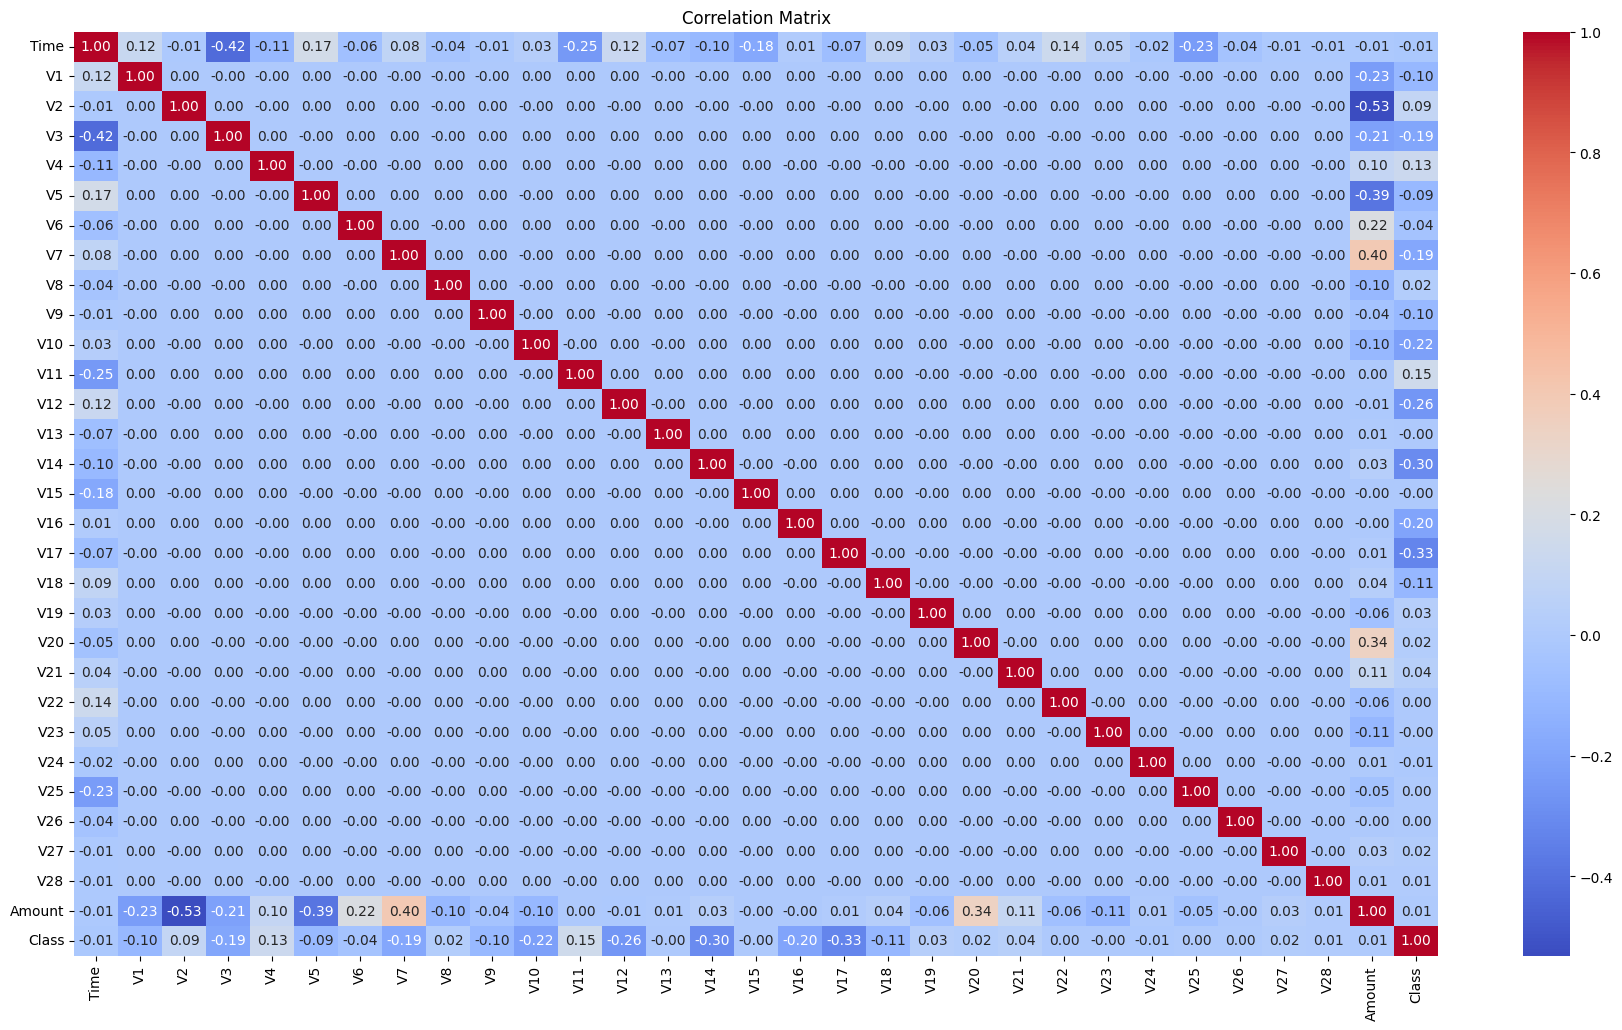

In [5]:
import seaborn as sns

# Перетворення в Pandas DataFrame для числових колонок
confusion_df = credit_card_df.toPandas()

# Обчислення кореляції
correlation_matrix = confusion_df.corr()

# Побудова heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()

Почнемо із найпростішого підходу, IQR (Interquartile Range) - вимірює розмах між 25-м та 75-м квартилями. Це допоможе визначити викиди в даних (потенційні шахрайські транзакції).
Важливо зазначити, що використання декількох фіч покращує результати.

In [9]:
# Descriptive statistics
credit_card_df.describe().show()

# For feature Ammoount
credit_card_df.select("Amount").describe().show()

features = ["Amount", "V11", "V4", "V2"]

outlier_conditions = []
for feature in features:
    # Compute IQR for each feature
    Q1 = credit_card_df.approxQuantile(feature, [0.25], 0)[0]
    Q3 = credit_card_df.approxQuantile(feature, [0.75], 0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Add condition for the current feature
    condition = (credit_card_df[feature] < lower_bound) | (credit_card_df[feature] > upper_bound)
    outlier_conditions.append(condition)

# Combine all outlier conditions
combined_outliers = outlier_conditions[0]
for condition in outlier_conditions[1:]:
    combined_outliers |= condition

# Filter outliers based on combined conditions
outliers = credit_card_df.where(combined_outliers)

# Analyze the outliers
outliers.select("Amount", "Class", "Time", "V11", "V4", "V2").describe().show()
outliers_df = outliers.select("Amount", "Class", "Time", "V11", "V4", "V2").where(outliers.Class == 1)

# Display results
print(f"Number of outliers: {outliers.count()}")
print(f"Number of outliers with Class 1: {outliers.where(outliers.Class == 1).count()}")



+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|  

25/01/01 15:07:17 ERROR TaskSchedulerImpl: Lost executor 0 on 172.21.0.8: worker lost: 172.21.0.8:34551 got disassociated
25/01/01 15:07:17 WARN TransportChannelHandler: Exception in connection from /172.21.0.8:37892
java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:401)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:434)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.ja

Також використаємо Z-оцінку, яка вимірює, наскільки далеко від середнього значення знаходиться точка даних. Це допоможе визначити викиди в даних.

In [7]:
from pyspark.sql import functions as F

mean_amount = credit_card_df.select("Amount").agg({"Amount": "mean"}).collect()[0][0]
stddev_amount = credit_card_df.select("Amount").agg({"Amount": "stddev"}).collect()[0][0]

# Calculate Z-score for Amount
credit_card_df = credit_card_df.withColumn('zscore_Amount', 
                                           (F.col('Amount') - mean_amount) / stddev_amount)


# Flaging fraud operations
credit_card_df = credit_card_df.withColumn('is_fraud', F.when(F.abs(F.col('zscore_Amount')) > 0.35, 1).otherwise(0))

# Number of fraud operations
print(credit_card_df.where(credit_card_df.is_fraud == 1).count())

# Number of fraud operations with Class 1 and predicted as fraud
z_score_df = credit_card_df.where((credit_card_df.is_fraud == 1) & (credit_card_df.Class == 1))
print(z_score_df.count())

42480
159


Додатково, проаналізуємо, саме набір шахрайських транзакцій, щоб зрозуміти, як вони відрізняються від нормальних транзакцій.

In [8]:
fraud_df = credit_card_df.where(credit_card_df.Class == 1)

non_fraud_df = credit_card_df.where(credit_card_df.Class == 0)

fraud_df.select("Amount", "Class", "Time", "V11", "V4", "V2").describe().show()  

non_fraud_df.select("Amount", "Class", "Time", "V11", "V4", "V2").describe().show()

z_score_df.select("Amount", "Class", "Time", "V11", "zscore_Amount").describe().show()



+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+
|summary|           Amount|Class|             Time|               V11|                V4|               V2|
+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+
|  count|              492|  492|              492|               492|               492|              492|
|   mean|122.2113211382114|  1.0|80746.80691056911|3.8001729113746077| 4.542029104423093|3.623778101982281|
| stddev|256.6832882977121|  0.0|47835.36513767505| 2.678604522510197|2.8733176878992315| 4.29121562613748|
|    min|              0.0|    1|            406.0| -1.70222840135659| -1.31327481447103|-8.40215367768915|
|    max|          2125.87|    1|         170348.0|  12.0189131816199|  12.1146718424589| 22.0577289904909|
+-------+-----------------+-----+-----------------+------------------+------------------+-----------------+

+-------+------------------

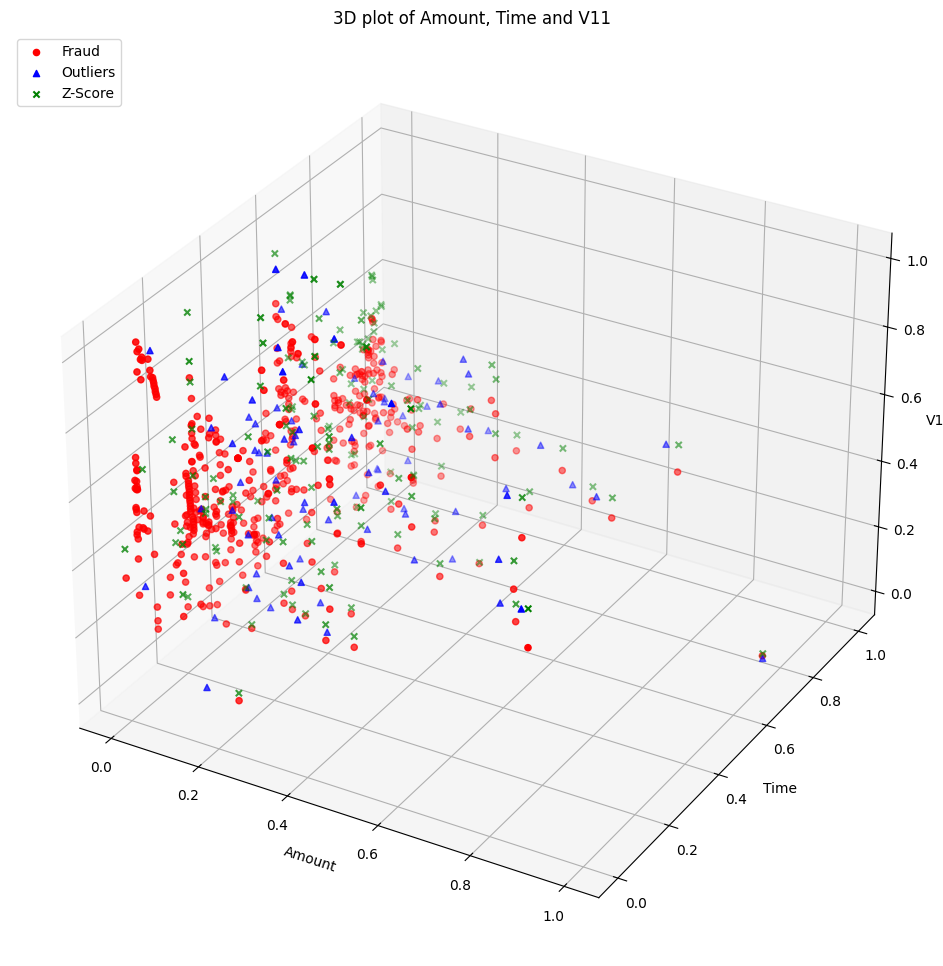

In [90]:
assembler = VectorAssembler(inputCols=["Amount", "Time", "V11"], outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Extract relevant columns for 3D plotting
fraud_data = assembler.transform(fraud_df)
non_fraud_data = assembler.transform(non_fraud_df)
outliers_data = assembler.transform(outliers_df)
z_score_data = assembler.transform(z_score_df)

#Fit and transform the  data
scaler_model_fraud = scaler.fit(fraud_data)
scaled_fraud_data = scaler_model_fraud.transform(fraud_data)

scaler_model_non_fraud = scaler.fit(non_fraud_data)
scaled_non_fraud_data = scaler_model_non_fraud.transform(non_fraud_data)

scaler_model_outliers = scaler.fit(outliers_data)
scaled_outliers_data = scaler_model_outliers.transform(outliers_data)

scaler_model_z_score = scaler.fit(z_score_data)
scaled_z_score_data = scaler_model_z_score.transform(z_score_data)

# Convert the scaled features to array
scaled_fraud_data = scaled_fraud_data.withColumn("scaled_features", vector_to_array("scaled_features"))
scaled_non_fraud_data = scaled_non_fraud_data.withColumn("scaled_features", vector_to_array("scaled_features"))
scaled_outliers_data = scaled_outliers_data.withColumn("scaled_features", vector_to_array("scaled_features"))
scaled_z_score_data = scaled_z_score_data.withColumn("scaled_features", vector_to_array("scaled_features"))

fraud_pd = scaled_fraud_data.select("scaled_features").toPandas()
non_fraud_pd = scaled_non_fraud_data.select("scaled_features").toPandas()
outliers_pd = scaled_outliers_data.select("scaled_features").toPandas()
z_score_pd = scaled_z_score_data.select("scaled_features").toPandas()

# Plot the 3D scatter plot
fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fraud_pd["scaled_features"].apply(lambda x: x[0]), fraud_pd["scaled_features"].apply(lambda x: x[1]), fraud_pd["scaled_features"].apply(lambda x: x[2]), c='r', marker='o', label='Fraud')
#ax.scatter(non_fraud_pd["scaled_features"].apply(lambda x: x[0]), non_fraud_pd["scaled_features"].apply(lambda x: x[1]), non_fraud_pd["scaled_features"].apply(lambda x: x[2]), c='g', marker='x', label='Non-Fraud')
ax.scatter(outliers_pd["scaled_features"].apply(lambda x: x[0]), outliers_pd["scaled_features"].apply(lambda x: x[1]), outliers_pd["scaled_features"].apply(lambda x: x[2]), c='b', marker='^', label='Outliers')
ax.scatter(z_score_pd["scaled_features"].apply(lambda x: x[0]), z_score_pd["scaled_features"].apply(lambda x: x[1]), z_score_pd["scaled_features"].apply(lambda x: x[2]), c='g', marker='x', label='Z-Score')

ax.set_title('3D plot of Amount, Time and V11')
ax.set_xlabel('Amount')
ax.set_ylabel('Time')
ax.set_zlabel('V11')

plt.legend(loc='upper left')
plt.show()
